# Sutton & Barto Reinforcement Learning Book

In [1]:
from platform import python_version
python_version()

'3.7.3'

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Chapter 4: Dynamic Programming

## Example 4.1 Demonstration of iterative policy evaluation

<IMG SRC="images/gridworld.png">

### First set up the GridWorld environment

In [3]:
class GridWorld:
    
    name = 'GridWorld'
    roles = [1]
    possible_n_players = [1]
    help_text = {
        'Move format': "(row, col)",
        'Move not available': "That action is not available.",
        'Number of players': "This game is for 1 player."
    }
    actions = {
        'l': (0, -1),
        'u': (-1, 0),
        'r': (0, 1),
        'd': (1, 0)
    }

    def __init__(self, size=(4, 4), moves=None):

        self.size = size

        # Create all states
        self.terminal_states = [(0, 0), (3, 3)]
        self.states = [(row, col) for row in range(size[0])
                       for col in range(size[1])
                       if (row, col) not in self.terminal_states]

        # Start in random state
        self.start_state = random.choice(self.states)

        # Store rewards for all possible possible rewards
        self.rewards = {**{s: -1.0 for s in self.states}, 
                        **{s: 0.0 for s in self.terminal_states}}

        # Store next state and reward for all possible
        # state transitions
        self.turn = self.roles[0]
        
        # Game state transitions are represented as 
        # (s, a): [p_1: (s2_1, r2_1), p_2: (s2_2, r2_2), ...]
        # where (s, a) is the current state and action, s2_i is 
        # the possible next_state, p_i is the probability o
        # that next state, and r2_i is the reward.  For a 
        # deterministic environment, the list should contain only
        # one item: (1.0, (s2, r)).
        self.transitions = {(s, a): [(1.0, (self.next_state(s, (self.turn, a)),
                                            self.rewards[s]))]
                            for s in self.states 
                            for a in self.actions}
        self.n_players = 1
        self.winner = None
        self.game_over = False
        self.reset()
        if moves is not None:
            for move in moves:
                self.make_move(move)

    def reset(self):
        
        self.moves = []
        self.state = self.start_state
        self.winner = None
        self.game_over = False

    def show_state(self):

        x = np.array(['_']*np.prod(game.size)).reshape(game.size)
        i_terminal_states = np.array(game.terminal_states).T
        x[i_terminal_states[0], i_terminal_states[1]] = 'X'
        x[game.state] = 'O'
        for row in x:
            print(" ".join(row))

    def available_moves(self, state=None):

        return list(self.actions.keys())

    def update_state(self, move):
        
        self.state = self.next_state(self.state, move)

    def next_state(self, state, move):

        role, action = move

        next_state = tuple(np.array(state) +
                           np.array(self.actions[action]))

        # Check if out of bounds
        if (next_state[0] < 0) or (next_state[0] >= self.size[0]) or \
            (next_state[1] < 0) or (next_state[1] >= self.size[1]):
            next_state = state

        if state in self.terminal_states:
            next_state = terminal_states[0]

        return next_state

    def make_move(self, move, show=False):
        
        assert self.game_over is False, "Game is over"

        self.update_state(move)
        self.moves.append(move)

        if show:
            role, action = move
            print("Player %s made move %s" % (str(role), str(action)))

        self.check_if_game_over()

    def get_rewards(self):
        """Returns reward resulting from the last action."""

        return {1: -1.0}

    def get_terminal_rewards(self):
        """Returns the reward after the terminal state."""

        assert self.game_over

        return {1: 0.0}   

    def check_if_game_over(self):

        if self.state in self.terminal_states:
            self.game_over, self.winner = True, self.turn

        return self.game_over

    def generate_state_key(self, state, role):

        return self.state

    def __repr__(self):

        return "GridWorld(%s)" % self.size.__repr__()

In [4]:
game = GridWorld()
game

GridWorld((4, 4))

In [5]:
game.roles, game.possible_n_players

([1], [1])

In [6]:
game.available_moves()

['l', 'u', 'r', 'd']

In [7]:
list(game.rewards.items())

[((0, 1), -1.0),
 ((0, 2), -1.0),
 ((0, 3), -1.0),
 ((1, 0), -1.0),
 ((1, 1), -1.0),
 ((1, 2), -1.0),
 ((1, 3), -1.0),
 ((2, 0), -1.0),
 ((2, 1), -1.0),
 ((2, 2), -1.0),
 ((2, 3), -1.0),
 ((3, 0), -1.0),
 ((3, 1), -1.0),
 ((3, 2), -1.0),
 ((0, 0), 0.0),
 ((3, 3), 0.0)]

In [8]:
list(game.transitions.items())[0:8]

[(((0, 1), 'l'), [(1.0, ((0, 0), -1.0))]),
 (((0, 1), 'u'), [(1.0, ((0, 1), -1.0))]),
 (((0, 1), 'r'), [(1.0, ((0, 2), -1.0))]),
 (((0, 1), 'd'), [(1.0, ((1, 1), -1.0))]),
 (((0, 2), 'l'), [(1.0, ((0, 1), -1.0))]),
 (((0, 2), 'u'), [(1.0, ((0, 2), -1.0))]),
 (((0, 2), 'r'), [(1.0, ((0, 3), -1.0))]),
 (((0, 2), 'd'), [(1.0, ((1, 2), -1.0))])]

In [9]:
game.show_state()

X _ _ _
_ _ _ _
_ _ _ _
_ O _ X


In [10]:
game.make_move((1, 'r'))
game.show_state()

X _ _ _
_ _ _ _
_ _ _ _
_ _ O X


In [11]:
game.get_rewards()

{1: -1.0}

In [12]:
while not game.game_over:
    game.make_move((1, random.choice(game.available_moves())))

In [13]:
game.get_terminal_rewards()

{1: 0.0}

### Create value functions

In [14]:
# State value-function
values = {s: 0.0 for s in game.states + game.terminal_states}
print("Length:", len(values))
values

Length: 16


{(0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (1, 0): 0.0,
 (1, 1): 0.0,
 (1, 2): 0.0,
 (1, 3): 0.0,
 (2, 0): 0.0,
 (2, 1): 0.0,
 (2, 2): 0.0,
 (2, 3): 0.0,
 (3, 0): 0.0,
 (3, 1): 0.0,
 (3, 2): 0.0,
 (0, 0): 0.0,
 (3, 3): 0.0}

In [15]:
def show_values(values, decimals=1):

    rows = max([k[0] for k, v in values.items()]) + 1
    cols = max([k[1] for k, v in values.items()]) + 1
    x = np.full((rows, cols), np.nan)
    for k, v in values.items():
        x[k] = round(v, decimals)
    print(x)

show_values(values)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [16]:
# Q (state, action) value function
q_values = {}
for s in game.states:
    for a in game.actions:
        q_values[(s, a)] = 0.0
print("Length:", len(q_values))
list(q_values.items())[0:8]

Length: 56


[(((0, 1), 'l'), 0.0),
 (((0, 1), 'u'), 0.0),
 (((0, 1), 'r'), 0.0),
 (((0, 1), 'd'), 0.0),
 (((0, 2), 'l'), 0.0),
 (((0, 2), 'u'), 0.0),
 (((0, 2), 'r'), 0.0),
 (((0, 2), 'd'), 0.0)]

In [17]:
def greedy_policy_with_state_values(game, state, action, values):
    """Returns the probability of taking the action in
    given state for a greedy policy with given state value
    function values.
    """

    actions = game.available_moves(state)

    # Requires the game's state-transition matrix
    action_values = {a: values[game.transitions[(state, a)][0][1][0]] 
                     for a in actions}
    v_max = max(action_values.items(), key=lambda x: x[1])

    return 1.0 if action == v_max[0] else 0.0

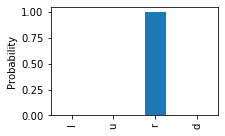

In [18]:
# Test above function
state = (1, 1)
actions = ['l', 'u', 'r', 'd']
test_values = {
 (1, 0): 1.0,
 (0, 1): 7.0,
 (1, 2): 9.0,
 (2, 1): 8.0
}
pd.Series([greedy_policy_with_state_values(game, state, a, test_values)
          for a in actions], index=actions).plot.bar(figsize=(3, 2))
plt.ylabel("Probability")
plt.show()

In [19]:
def greedy_policy_with_q_values(game, state, action, q_values):
    """Returns the probability of taking the action in
    given state for a greedy policy with given state-action
    value function q_values."""
    
    actions = game.available_moves(state)
    action_values = {a: q_values[(state, a)] for a in actions}
    v_max = max(action_values.items(), key=lambda x: x[1])

    return 1.0 if action == v_max[0] else 0.0

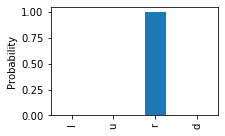

In [20]:
# Test above function
state = (1, 1)
actions = ['l', 'u', 'r', 'd']
test_q_values = {
 ((1, 1), 'l'): 1.0,
 ((1, 1), 'u'): 7.0,
 ((1, 1), 'r'): 9.0,
 ((1, 1), 'd'): 8.0
}
pd.Series([greedy_policy_with_q_values(game, state, a, test_q_values)
          for a in actions], index=actions).plot.bar(figsize=(3, 2))
plt.ylabel("Probability")
plt.show()

In [21]:
def random_policy(game, state, action, values=None):

    actions = game.available_moves(state=state)

    return 1.0/len(game.actions)

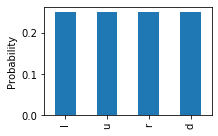

In [22]:
# Test above function
state = (1, 1)
actions = ['l', 'u', 'r', 'd']
pd.Series([random_policy(game, state, a)
          for a in actions], index=actions).plot.bar(figsize=(3, 2))
plt.ylabel("Probability")
plt.show()

In [23]:
def policy_action(game, policy, state, values):

    actions = game.available_moves(state)
    probs = [policy(game, state, a, values) for a in actions]

    return np.random.choice(actions, p=probs)

In [24]:
# Test above function
[policy_action(game, random_policy, (1, 1), values) for i in range(8)]

['l', 'd', 'l', 'd', 'u', 'd', 'l', 'u']

In [25]:
def update_values(game, policy, values, lr):
    """Sweeps through all game states and uses the
    Bellman equation (Equation 4.5 in Sutton & Barto
    book) to update the state value function assuming
    the given policy.

    Requires game object to have a transitions
    dictionary of all (next_states, rewards) given
    all (states, actions).
    """

    v = values.copy()

    for s in game.states:

        actions = game.available_moves(s)
        sum_values = 0.0

        for a in actions:
            p_action = policy(game, s, a, values)
            for p_state, (s2, reward) in game.transitions[(s, a)]:
                if s2 in game.states:
                    sum_values += p_action*p_state*(reward + lr*values[s2])
                elif s2 in game.terminal_states:
                    sum_values += p_action*p_state*reward
        v[s] = sum_values

    return v

In [26]:
def evaluate_policy(policy, game, values, lr=1.0, theta=0.01, 
                    max_iter=1000, show=True, show_values=None):
    """Carries out repeated value-updates with the
    given policy until maximum iterations reached
    or the maximum absolute change in values is less
    than theta.  Returns updated values.
    """

    iteration = 0
    if show:
        print("\nk =", iteration)
        if show_values:
            show_values(values)

    while iteration < max_iter:

        updated_values = update_values(game, policy, values, lr=lr)

        delta = np.abs(
            np.array(list(updated_values.values())) -
            np.array(list(values.values()))
        ).max()
        
        values = updated_values
        iteration += 1
        
        if show:
            print("\nk =", iteration)
            if show_values:
                show_values(values)

        if delta < theta:
            break
    
    if iteration == max_iter:
        print("\nMaximum iterations reached.")
    else:
        print("\nConverged to delta < %f after %d iterations" % 
              (theta, iteration))
    
    return values

### 1. Estimate optimal values using equi-probable random policy

In [27]:
values = {s: 0.0 for s in game.states + game.terminal_states}

In [28]:
values = evaluate_policy(random_policy, game, values, max_iter=10, 
                         show=True, show_values=show_values)


k = 0
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

k = 1
[[ 0. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1.  0.]]

k = 2
[[ 0.  -1.8 -2.  -2. ]
 [-1.8 -2.  -2.  -2. ]
 [-2.  -2.  -2.  -1.8]
 [-2.  -2.  -1.8  0. ]]

k = 3
[[ 0.  -2.4 -2.9 -3. ]
 [-2.4 -2.9 -3.  -2.9]
 [-2.9 -3.  -2.9 -2.4]
 [-3.  -2.9 -2.4  0. ]]

k = 4
[[ 0.  -3.1 -3.8 -4. ]
 [-3.1 -3.7 -3.9 -3.8]
 [-3.8 -3.9 -3.7 -3.1]
 [-4.  -3.8 -3.1  0. ]]

k = 5
[[ 0.  -3.7 -4.7 -4.9]
 [-3.7 -4.5 -4.8 -4.7]
 [-4.7 -4.8 -4.5 -3.7]
 [-4.9 -4.7 -3.7  0. ]]

k = 6
[[ 0.  -4.2 -5.5 -5.8]
 [-4.2 -5.2 -5.6 -5.5]
 [-5.5 -5.6 -5.2 -4.2]
 [-5.8 -5.5 -4.2  0. ]]

k = 7
[[ 0.  -4.7 -6.3 -6.7]
 [-4.7 -5.9 -6.4 -6.3]
 [-6.3 -6.4 -5.9 -4.7]
 [-6.7 -6.3 -4.7  0. ]]

k = 8
[[ 0.  -5.2 -7.  -7.5]
 [-5.2 -6.5 -7.1 -7. ]
 [-7.  -7.1 -6.5 -5.2]
 [-7.5 -7.  -5.2  0. ]]

k = 9
[[ 0.  -5.7 -7.7 -8.2]
 [-5.7 -7.2 -7.8 -7.7]
 [-7.7 -7.8 -7.2 -5.7]
 [-8.2 -7.7 -5.7  0. ]]

k = 10
[[ 0.  -6.1 -8.4 -9. ]
 [-6.1 -7.7 -8.4 

### 2. Greedy policy

In [29]:
values

{(0, 1): -6.137969970703125,
 (0, 2): -8.35235595703125,
 (0, 3): -8.967315673828125,
 (1, 0): -6.137969970703125,
 (1, 1): -7.737396240234375,
 (1, 2): -8.427825927734375,
 (1, 3): -8.35235595703125,
 (2, 0): -8.35235595703125,
 (2, 1): -8.427825927734375,
 (2, 2): -7.737396240234375,
 (2, 3): -6.137969970703125,
 (3, 0): -8.967315673828125,
 (3, 1): -8.35235595703125,
 (3, 2): -6.137969970703125,
 (0, 0): 0.0,
 (3, 3): 0.0}

In [30]:
def show_actions(game, policy, values):

    x = np.array(['_']*np.prod(game.size), dtype='<U1').reshape(game.size)
    for s in game.states:
        x[s] = policy_action(game, policy, s, values)
    
    print(x.__repr__())

# Optimal actions
show_actions(game, greedy_policy_with_state_values, values)

array([['_', 'l', 'l', 'l'],
       ['u', 'l', 'l', 'd'],
       ['u', 'u', 'r', 'd'],
       ['u', 'r', 'r', '_']], dtype='<U1')


In [31]:
game.states

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2)]

In [32]:
# Define true optimal actions so we can confirm
# if a policy is optimal
array_of_actions = np.array([
    ['', 'l', 'l', 'ld'],
    ['u', 'lu', 'lurd', 'd'],
    ['u', 'lurd', 'rd', 'd'],
    ['ur', 'r', 'r', '']
], dtype='<U4')
optimal_actions = {index: x for index, x in 
                   np.ndenumerate(array_of_actions)
                   if index not in game.terminal_states}
optimal_actions

{(0, 1): 'l',
 (0, 2): 'l',
 (0, 3): 'ld',
 (1, 0): 'u',
 (1, 1): 'lu',
 (1, 2): 'lurd',
 (1, 3): 'd',
 (2, 0): 'u',
 (2, 1): 'lurd',
 (2, 2): 'rd',
 (2, 3): 'd',
 (3, 0): 'ur',
 (3, 1): 'r',
 (3, 2): 'r'}

In [33]:
def test_policy(game, policy, values, optimal_actions):
    """Returns an accuracy score for policy according to
    how many optimal actions it makes in each state based
    on optimal_actions.
    """

    a_array = np.zeros(game.size, dtype=bool)
    for s, opt in optimal_actions.items():
        a = policy_action(game, policy, s, values)
        if a in opt:
            a_array[s] = True
        else:
            a_array[s] = False
    
    return a_array.sum()/len(game.states)

In [34]:
test_policy(game, greedy_policy_with_state_values, values, optimal_actions)

1.0

### 3. Calculate Q-values

In [35]:
def q_values_from_values(game, values, lr=1.0):

    q_values = {}
    for s in game.states:

        sum_values = 0
        actions = game.available_moves(s)
        for a in actions:
            sum_values = 0.0
            for p_state, (s2, reward) in game.transitions[(s, a)]:
                if s2 in game.states:
                    sum_values += p_state*(reward + lr*values[s2])
                elif s2 in game.terminal_states:
                    sum_values += p_state*reward

            # Q-value is value of next state + reward (?)
            v_next = sum_values
            q_values[(s, a)] = v_next

    return q_values

In [36]:
game.transitions[((1, 0), 'l')]

[(1.0, ((1, 0), -1.0))]

In [37]:
q_values = q_values_from_values(game, values)
q_values

{((0, 1), 'l'): -1.0,
 ((0, 1), 'u'): -7.137969970703125,
 ((0, 1), 'r'): -9.35235595703125,
 ((0, 1), 'd'): -8.737396240234375,
 ((0, 2), 'l'): -7.137969970703125,
 ((0, 2), 'u'): -9.35235595703125,
 ((0, 2), 'r'): -9.967315673828125,
 ((0, 2), 'd'): -9.427825927734375,
 ((0, 3), 'l'): -9.35235595703125,
 ((0, 3), 'u'): -9.967315673828125,
 ((0, 3), 'r'): -9.967315673828125,
 ((0, 3), 'd'): -9.35235595703125,
 ((1, 0), 'l'): -7.137969970703125,
 ((1, 0), 'u'): -1.0,
 ((1, 0), 'r'): -8.737396240234375,
 ((1, 0), 'd'): -9.35235595703125,
 ((1, 1), 'l'): -7.137969970703125,
 ((1, 1), 'u'): -7.137969970703125,
 ((1, 1), 'r'): -9.427825927734375,
 ((1, 1), 'd'): -9.427825927734375,
 ((1, 2), 'l'): -8.737396240234375,
 ((1, 2), 'u'): -9.35235595703125,
 ((1, 2), 'r'): -9.35235595703125,
 ((1, 2), 'd'): -8.737396240234375,
 ((1, 3), 'l'): -9.427825927734375,
 ((1, 3), 'u'): -9.967315673828125,
 ((1, 3), 'r'): -9.35235595703125,
 ((1, 3), 'd'): -7.137969970703125,
 ((2, 0), 'l'): -9.352355957

In [38]:
greedy_policy_with_q_values(game, (1, 0), 'r', q_values)

0.0

In [39]:
greedy_policy_with_q_values(game, (1, 0), 'u', q_values)

1.0

In [40]:
test_policy(game, greedy_policy_with_q_values, q_values, optimal_actions)

1.0

### Exercise 4.1

In Example 4.1, if $\pi$ is the equiprobable random policy,

- What is $q_\pi(11,down)$?
- What is $q_\pi(7,down)$?

$q_\pi(11,down)$:

In [41]:
q_values[((2, 3), 'd')]

-1.0

$q_\pi(7,down)$:

In [42]:
q_values[((1, 3), 'd')]

-7.137969970703125

## Example 4.2 Jack’s Car Rental

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \\$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \\$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is

$n$ is $\frac{\lambda^n}{n!}\mathrm{e}^{-\lambda}$, where $\lambda$ is the expected number.

Suppose $\lambda$ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be $\gamma = 0.9$ and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

In [43]:
from scipy.special import factorial

n_max = 20
n = np.arange(0, n_max + 1)
lam = 4

def prob_request(n, lam):
    
    return lam**n/factorial(n)*np.exp(-lam)

# This is equivalent to poisson.pmf(k=n, mu=lam)

from scipy.stats import poisson

np.isclose(poisson.pmf(k=n, mu=lam), 
           prob_request(n, lam)).all()

True

In [44]:
from scipy.special import factorial

class JacksCarRental:

    name = "Jack's Car Rental"
    roles = [1]
    possible_n_players = [1]
    help_text = {
        'Move format': "(row, col)",
        'Move not available': "That action is not available.",
        'Number of players': "This game is for 1 player."
    }
    
    def __init__(self, n_sizes=[20, 20], lam_requests=[3, 4], 
                 lam_returns=[3, 2], move_max=5, credit=10,
                 move_cost=2, start_state=[10, 10], 
                 moves=None):

        self.n_locations = len(n_sizes)
        self.n_sizes = n_sizes
        self.lam_requests = lam_requests
        self.lam_returns = lam_returns
        self.credit = credit
        self.move_cost = move_cost
        self.start_state = start_state
        self.n = np.arange(0, n_max + 1)

        # Probabilities of number of requests/returns at
        # each location
        # TODO: Delete, don't need this
        #self.p_requests = [poisson.pmf(k=n, mu=lam)
        #                   for lam in lam_requests]
        #self.p_returns = [poisson.pmf(k=n, mu=lam)
        #                  for lam in lam_returns]

        # Create all states
        self.states = [(c1, c2) 
                       for c1 in range(n_sizes[0] + 1) 
                       for c2 in range(n_sizes[1] + 1)]

        self.turn = self.roles[0]
        
        self.n_players = 1
        self.winner = None
        self.game_over = False
        self.reset()
        if moves is not None:
            for move in moves:
                self.make_move(move)

    def reset(self):
        
        self.moves = []
        self.state = self.start_state
        self.winner = None
        self.game_over = False

    def show_state(self):

        print(self.state)

    def available_moves(self, state=None):
        """Determine how many cars are available for moving.
        Return as a list of number of cars movable.
        """

        if state is None:
            state = self.state
        s1, s2 = state

        actions = list(range(-min(s2, n_max - s1), 
                             min(s1, n_max - s2) + 1))

        return actions
    
    def update_state(self, move):
        
        self.state = self.next_state(self.state, move)

    def next_state(self, state, move):

        role, cars_moved = move
        s1, s2 = state

        cars_requested = [np.random.poisson(lam=lam) 
                          for lam in self.lam_requests]
        cars_returned = [np.random.poisson(lam=lam) 
                         for lam in self.lam_returns]

        cars_rented = [None, None]
        for i in range(2):

            # Rent cars if available
            cars_rented[i] = min(state[i], cars_requested[i])

            # Return cars if space available
            cars_returned[i] = min(n_max - state[i], cars_returned[i])

        s1 = s1 + cars_rented[0] - cars_returned[0] - cars_moved
        s2 = s2 + cars_rented[1] - cars_returned[1] + cars_moved

        self.cost = 2*cars_moved - 10*sum(cars_rented)

        return (s1, s2)
    
    def make_move(self, move, show=False):
        
        assert self.game_over is False, "Game is over"

        self.update_state(move)
        self.moves.append(move)

        if show:
            role, action = move
            print("Player %s made move %s" % (str(role), str(action)))

        self.check_if_game_over()

    def get_rewards(self):
        """Returns reward resulting from the last action."""

        return {1: self.cost}

    def get_terminal_rewards(self):
        """Returns the reward after the terminal state."""

        assert self.game_over

        return {1: 0.0}   

    def check_if_game_over(self):

        if self.state in self.terminal_states:
            self.game_over, self.winner = True, self.turn

        return self.game_over

    def generate_state_key(self, state, role):

        return self.state

    def __repr__(self):

        return "GridWorld(%s)" % self.size.__repr__()

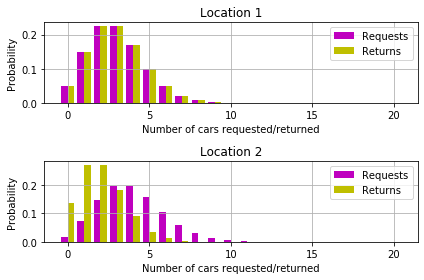

In [45]:
game = JacksCarRental()

p_requests = [poisson.pmf(k=n, mu=lam)
              for lam in game.lam_requests]
p_returns = [poisson.pmf(k=n, mu=lam)
            for lam in game.lam_returns]
             
for location in range(2):

    # Plot pdfs for location 1
    ax = plt.subplot(211 + location)
    ax.bar(n-0.2, p_requests[location], width=0.4, color='m', 
           align='center', label="Requests")
    ax.bar(n+0.2, p_returns[location], width=0.4, color='y',
           align='center', label="Returns")
    ax.set_title("Location %d" % (location + 1))
    plt.xlabel("Number of cars requested/returned")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [46]:
len(game.states)

441

In [47]:
game.states[0:10]

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9)]

In [48]:
# Create state value-function
values = {s: 0 for s in game.states}
list(values.items())[0:10]

[((0, 0), 0),
 ((0, 1), 0),
 ((0, 2), 0),
 ((0, 3), 0),
 ((0, 4), 0),
 ((0, 5), 0),
 ((0, 6), 0),
 ((0, 7), 0),
 ((0, 8), 0),
 ((0, 9), 0)]

In [49]:
game.next_state(game.state, (1, 1))

(9, 10)

In [50]:
# Test
game.next_state(game.state, (1, 10))

(-3, 24)

In [51]:
def show_values(values, r=1):
    """Displays the values rounded to r decimal places.
    """
    
    v_array  = np.zeros((n_max+1, n_max+1))
    for s, v in values.items():
        v_array[s] = v
    print(v_array.round(r))

show_values(values)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [52]:
# TODO: Needs testing
#evaluate_policy(random_policy, states, actions, transitions=None,  
#                values=values, lr=1.0, theta=0.01, max_iter=10,
#                show=True, show_values=show_values)

## Chapter 6: TD Learning

### Example 6.2 Random walk

In [53]:
from gamelearner import GameController, RandomPlayer, TDLearner
from randomwalk import RandomWalkGame

In [54]:
game = RandomWalkGame()
game.possible_n_players

[1]

In [55]:
game.size

5

In [56]:
game.states

['T1', 'A', 'B', 'C', 'D', 'E', 'T2']

In [57]:
game.show_state()

T1 _ _ C _ _ T2


In [58]:
game.make_move((1, 'r'), show=True)

Player 1 made move 'r'


In [59]:
game.show_state()

T1 _ _ _ D _ T2


In [60]:
game.get_rewards()

{1: 0.0}

In [61]:
game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ E T2


In [62]:
game.get_rewards()

{1: 0.0}

In [63]:
game.make_move((1, 'l'))
game.show_state()

T1 _ _ _ D _ T2


In [64]:
game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ E T2


In [65]:
game.make_move((1, 'r'))
game.show_state()

T1 _ _ _ _ _ T2


In [66]:
game.game_over

True

In [67]:
game.get_rewards()

{1: 0.0}

In [68]:
game.get_terminal_rewards()

{1: 1.0}

In [69]:
game = RandomWalkGame()
player = RandomPlayer()
ctrl = GameController(game, [player])
ctrl.play(show=False)
ctrl.announce_result()

T1 _ _ _ _ _ T2
Game over!
RANDOM won in 13 moves


In [70]:
game.reset()
player = TDLearner(initial_value=0.5)
ctrl = GameController(game, [player])
ctrl.play(show=True)

Game of Random Walk with 1 players ['TD']
T1 _ _ C _ _ T2
TD's turn (l/r): r
TD got 0.0 reward.
T1 _ _ _ D _ T2
TD's turn (l/r): l
TD got 0.0 reward.
T1 _ _ C _ _ T2
TD's turn (l/r): r
TD got 0.0 reward.
T1 _ _ _ D _ T2
TD's turn (l/r): r
TD got 0.0 reward.
T1 _ _ _ _ E T2
TD's turn (l/r): r
TD got 0.0 reward.
TD got 1.0 reward.
T1 _ _ _ _ _ T2
Game over!
TD won in 5 moves


In [71]:
player.value_function

{'C': 0.5, 'D': 0.5, 'T2': 0.505}

### TD(0) Updates on Random Walk

Equation (6.2)

$V(S_t) \leftarrow V(S_t) + \alpha [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)]$

In [72]:
size = 5
game = RandomWalkGame(size=size)
gamma = 1.0
learning_rate = 0.1

initial_value = 0.5
value_function = {s: initial_value for s in game.states}
value_function['T1'] = 0.0
value_function['T2'] = 0.0

episodes_to_record = [0, 1, 10, 100]
value_sets = {}

np.random.seed(5)

n_iters = 1001
for iteration in range(n_iters):
    
    if iteration in episodes_to_record:
        value_sets[iteration] = value_function.copy()

    past_states = [game.state]

    while True:

        # Behaviour policy
        move = np.random.choice(game.available_moves())
        game.make_move([1, move])
        past_states.append(game.state)

        reward = game.get_rewards()[1]

        # TD(0) update
        if not game.game_over:
            value_function[past_states[-2]] += \
                    learning_rate*(
                            reward + gamma*value_function[past_states[-1]] -
                            value_function[past_states[-2]]
                    )
        else:
            reward = game.get_terminal_rewards()[1]
            value_function[past_states[-2]] += \
                learning_rate*(reward - value_function[past_states[-2]])
            break

    game.reset()

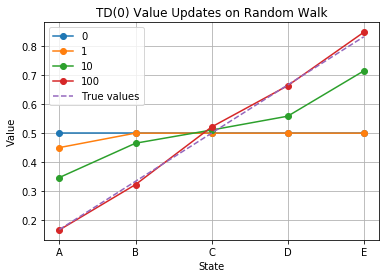

In [73]:
states = game.states[1:size+1]
true_values = pd.Series([x*(1/(size+1)) for x in range(size+2)][1:size+1], 
                       index=states)

fig, ax = plt.subplots()

for i, value_function in value_sets.items():
    values = list(value_function.values())[1:size+1]
    ax.plot(states, values, marker='o', label=str(i))
ax.plot(true_values.index, true_values, linestyle='--', label='True values')
plt.title('TD(0) Value Updates on Random Walk')
ax.set_xlabel('State')
ax.set_ylabel('Value')
plt.legend()
plt.savefig("random_walk_td0.pdf")
plt.grid()

## Chapter 7: n-step Bootstrapping

## n-step TD

<IMG SRC="tdlambda.png">

### Example 7.1 Random walk

n-step TD Updates on Random Walk

In [74]:
size = 19
game = RandomWalkGame(size=size)

# Set rewards for this exercise
game.terminal_rewards = {'T1': -1.0, 'T2': 1.0}

# Initialization of parameters
gamma = 1.0
learning_rate = 0.1
initial_value = 0.0
n = 5

# Initialise value function
value_function = {
    s: 0.0 if s in game.terminal_states else initial_value
    for s in game.states
}

episodes_to_record = [0, 1, 10, 100]
value_sets = {}

np.random.seed(5)

n_iters = 101
for iteration in range(n_iters):
    
    if iteration in episodes_to_record:
        value_sets[iteration] = value_function.copy()

    past_states = [game.state]
    past_rewards = [None]
    
    T = 999999
    t = 0
    while True:

        # Behaviour policy
        if t < T:
            move = np.random.choice(game.available_moves())
            game.make_move([1, move])
            past_states.append(game.state)
            if not game.game_over:
                reward = game.get_rewards()[1]
            else:
                reward = game.get_terminal_rewards()[1]
            past_rewards.append(reward)
            if game.game_over:
                T = t + 1

        #import pdb; pdb.set_trace()

        # State to be updated
        tau = t - n + 1
        
        # TD(λ) update
        if tau >= 0:
            g = 0
            for i in range(tau + 1, min(tau + n, T) + 1):
                g += gamma**(i - tau - 1)*past_rewards[i]
            if tau + n < T:
                g += gamma**n*value_function[past_states[tau + n]]

            value_function[past_states[tau]] += \
                learning_rate*(g - value_function[past_states[tau]])
        
        t += 1
        if tau == T - 1:
            break

    game.reset()

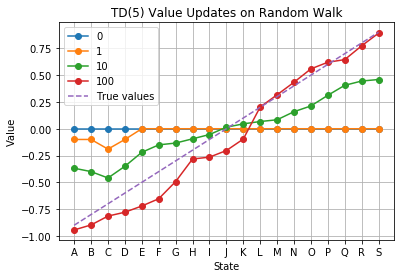

In [75]:
states = game.states[1:size+1]
true_values = pd.Series([(2*x*(1/(size+1)) - 1)
                         for x in range(size+2)][1:size+1], 
                        index=states)

fig, ax = plt.subplots()

for i, value_function in value_sets.items():
    values = list(value_function.values())[1:size+1]
    ax.plot(states, values, marker='o', label=str(i))
ax.plot(true_values.index, true_values, linestyle='--', 
        label='True values')
plt.title('TD(%d) Value Updates on Random Walk' % n)
ax.set_xlabel('State')
ax.set_ylabel('Value')
plt.legend()
plt.savefig("random_walk_td%d_19.pdf" % n)
plt.grid()

In [76]:
pd.concat([pd.DataFrame(value_sets),
           pd.Series(true_values, name='True Values')], axis=1, sort=False)

,0,1,10,100,True Values
A,0.0,-0.10,-0.368335,-0.943730,-0.9
B,0.0,-0.10,-0.399838,-0.897351,-0.8
C,0.0,-0.19,-0.459379,-0.814759,-0.7
D,0.0,-0.10,-0.350100,-0.778533,-0.6
E,0.0,0.00,-0.220020,-0.720796,-0.5
F,0.0,0.00,-0.150461,-0.653122,-0.4
G,0.0,0.00,-0.133647,-0.492940,-0.3
H,0.0,0.00,-0.094026,-0.282326,-0.2
I,0.0,0.00,-0.054104,-0.265055,-0.1
J,0.0,0.00,0.013983,-0.203500,0.0


### RMS error metric

In [77]:
# RMS error metric
def rms_error(x, true_values):
    """Root-mean-squared error in values
    """
    
    return np.sqrt(np.sum((x - true_values)**2)/len(x))

# Use array version here
true_values = np.array(
    [(game.terminal_rewards['T1']*(1 - x) + game.terminal_rewards['T2']*x)
     for x in np.linspace(0.0, 1.0, game.size + 2)]
)[1:game.size+1]

values = np.array(list(value_sets[100].values()))[1:size+1]
rms_error(values, true_values)

0.1317165375145056

### n-step TD - effect of variation in n (and alpha)

In [78]:
size = 19
game = RandomWalkGame(size=size)
game.terminal_rewards = {'T1': -1.0, 'T2': 1.0}


# Initialization of parameters
initial_value = 0.0
gamma = 1.0

# Iterate over learning_rates and n_values
learning_rates = np.linspace(0.01, 1.0, 100)
n_values = [2**i for i in range(8)]

rms_error_sets = {}

# TODO: Should be repeating the test 100 times for each
# pair of n, alpha values and averaging the results.
for n in n_values:

    # OVERRIDE
    #n = 1

    rms_results = []

    for learning_rate in learning_rates:

        # Initialise value function
        value_function = {
            s: 0.0 if s in game.terminal_states else initial_value
            for s in game.states
        }
        
        rng = random.Random(5)

        n_iters = 10
        for iteration in range(n_iters):

            past_states = [game.state]
            past_rewards = [None]

            T = 999999
            t = 0
            while True:

                # Behaviour policy
                if t < T:
                    move = rng.choice(game.available_moves())
                    game.make_move([1, move])
                    past_states.append(game.state)
                    if not game.game_over:
                        reward = game.get_rewards()[1]
                    else:
                        reward = game.get_terminal_rewards()[1]
                    past_rewards.append(reward)
                    if game.game_over:
                        T = t + 1

                # State to be updated
                tau = t - n + 1

                # TD(λ) update
                if tau >= 0:
                    
                    g = 0
                    for i in range(tau + 1, min(tau + n, T) + 1):
                        g += gamma**(i - tau - 1)*past_rewards[i]
                    if tau + n < T:
                        g += gamma**n*value_function[past_states[tau + n]]

                    value_function[past_states[tau]] += \
                                learning_rate*(g - value_function[past_states[tau]])

                t += 1
                if tau == T - 1:
                    break

            game.reset()
            #break

        values = np.array(list(value_function.values())[1:size+1])
        rms_results.append(rms_error(values, true_values))
        #break

    rms_error_sets[n] = rms_results
    
    # Override
    #break

print(n, rms_results[:3])

128 [0.5067675989278085, 0.5346220655366686, 0.5882351606556061]


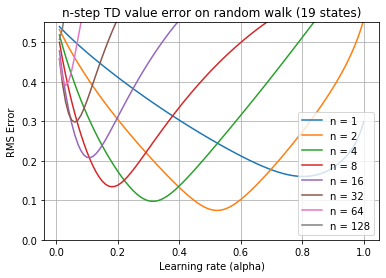

In [79]:
# Plot results
states = game.states[1:size+1]

fig, ax = plt.subplots()

for n, rms_errors in rms_error_sets.items():
    ax.plot(learning_rates, rms_errors, label='n = %d' % n)
plt.title('n-step TD value error on random walk (%d states)' % game.size)
ax.set_xlabel('Learning rate (alpha)')
ax.set_ylabel('RMS Error')
ax.set_ylim(0.0, 0.55)
plt.legend()
plt.grid()
plt.savefig("random_walk_tdl_%d.pdf" % game.size)
plt.show()

### n-step TD - Preparing classes for adding to game-learner

In [80]:
from abc import ABC, abstractmethod

# Initialization of agent
class Agent:
    
    def __init__(self, policy, name=None, initial_value=0.0, n=1,
                 gamma=1.0, learning_rate=0.1):

        self.name = name
        self.policy = policy
        self.initial_value = initial_value
        self.n = n
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.saved_game_states = None
        self.past_rewards = None
        self.value_function = None
        self.updates_on = True

    def initialize(self, game, role):
        
        # Initialise value function
        self.value_function = {}
        
        self.saved_game_states = {}
        self.saved_rewards = {}  # TODO: Need to replace past_rewards
        
        # This must be called before starting the first game
        self.reset_game_information(game, role)
        
        # Some behaviour policies need reseting (e.g. random seed)
        self.policy.reset()

    def get_value(self, state_key):
        """Returns a value from TDLearner's value_function for the
        game state represented by state_key. If there is no item for
        that state, returns the initial_value instead.
        """

        return self.value_function.get(state_key, self.initial_value)

    def save_state(self, game, state_key):
        """Adds state_key to a list of keys stored in dictionary
        self.saved_game_states for each game being played.
        """

        self.saved_game_states.get(game, []).append(state_key)

    def decide_next_move(self, game, role, show=False):
        """Returns the agent's next move in game (using its policy)
        and assuming they are playing this role.

        Args:
            game (Game): Game being played.
            role (object): Role that the player is playing.
            show (bool): Print messages if True.

        Returns:
            move (tuple): Tuple containing (role, action).
        """

        action = self.policy.choose_action(game, role)
        move = (role, action)
        
        # Save chosen after-state for learning updates later
        # TODO: Should save timestep with it
        next_state = game.next_state(game.state, move)
        next_state_key = game.generate_state_key(next_state, role)
        self.save_state(game, next_state_key)

        if show:
            move_format = game.help_text['Move format']
            print("%s's turn (%s): %s" % (self.name, move_format,
                                          str(position)))

        return move

    def make_move(self, game, role, show=False):
        """Ask player to make a move.  This method will call
        the player's decide_next_move method and will then
        execute the resulting move in the game.

        Args:
            game (Game): Game that player is playing.
            role (int): Role that the player is playing.
            show (bool): Print messages if True.
        """

        assert not game.game_over, "Can't make move. Game is over."

        # Player needs to trigger game start if method exists
        if len(game.moves) == 0:
            try:
                game.start()
            except AttributeError:
                pass

        move = self.decide_next_move(game, role, show)
        game.make_move(move)
        
        # Keep track of time-steps here
        #self.t += 1

    def update(self, game, reward, show=False):
        """Update TDLearner's value function based on current reward 
        from game.  This gets called by GameController during a game
        whenever rewards are distributed and the player has received
        one.

        Args:
            game (Game): Game that player is playing.
            role (int): Player role.
            reward (float): Reward value.
            show (bool): Print a message if True.
        """

        # Save the current state and reward for future value
        # updates.
        self.past_rewards.append(reward)
        
        if self.updates_on:
            prev_states = self.saved_game_states[game]
            prev_rewards = self.past_rewards
            self.td_lambda_update(prev_states, prev_rewards)

        if show:
            print("%s got %s reward." % (self.name, reward))

    def td_lambda_update(self, prev_states, prev_rewards, tau=None, 
                         t_max=np.inf):
        """Updates the value for the past state that occurred
        in timestep tau using the Bellman equation.  If tau is 
        not provided, then it is calculated as follows:
        
        tau = t - n + 1
        
        Where:
            t is the current timestep (self.t)
            n is the lambda value (self.n)  
        
        If tau < 0 no update is possible so none is made.
        
        Args:
            tau (int): Previous time-step to be updated.
            t_max (int or np.inf): The maximum timestep to include.  
                Set to infinity or a high number if you want to
                include all timesteps from tau to tau + n.  Set
                to t if the game has eneded.
        """

        # Set tau, the timestep of the state that will have its
        # value updated
        
        # TODO: Is there a better way to update self.t?
        #self.t = len(self.saved_game_states[game]) + 1
        if tau is None:
            tau = self.t - self.n + 1

        if tau >= 0:

            assert tau < len(prev_states), "Not enough past states."

            n = self.n
            g = 0
            for i in range(tau + 1, min(tau + n, t_max) + 1):
                # TODO: Can this be vectorized?
                g += self.gamma**(i - tau - 1)*prev_rewards[i]
            if tau + n < t_max:
                g += self.gamma**n*self.get_value(prev_states[tau + n])

            # Update value of state at timestep tau
            state_key = prev_states[tau]
            agent.value_function[state_key] = self.get_value(state_key) + \
                self.learning_rate*(g - self.get_value(state_key))

    def reset_game_information(self, game, role):
        """Delete state and reward history for specified game
        and set timestep (t) to zero.
        """

        state_key = game.generate_state_key(game.state, role)
        self.saved_game_states[game] = [state_key]
        self.past_rewards = [None]
        self.t = 0

    def gameover(self, game):

        # Complete final state-value updates for timesteps tau
        # to current (terminal) timestep
        T = self.t
        for tau in range(self.t - self.n + 1, T):
            prev_states = self.saved_game_states[game]
            prev_rewards = self.past_rewards
            self.td_lambda_update(prev_states, prev_rewards, tau=tau, 
                                  t_max=T)

class Policy(ABC):
    
    def __init__(self, name):
        
        self.name = name
    
    @abstractmethod
    def choose_action(self, game, role):
        
        pass


class RandomPolicy(Policy):
    
    def __init__(self, name="RANDOM", seed=None):
        
        super().__init__(name)
        
        # Independent random number generator for sole use
        # by this instance
        self.seed = seed
        self.reset()

    def choose_action(self, game, role):
        
        available_moves = game.available_moves()
        
        action = self.rng.choice(available_moves)
        
        return action
    
    def reset(self):
        
        self.rng = random.Random(self.seed)


In [81]:
size = 19
game = RandomWalkGame(size=size)
game.terminal_rewards = {'T1': -1.0, 'T2': 1.0}

agent = Agent(RandomPolicy(seed=5), name="Random", initial_value=0.0, 
              gamma=1.0)

# Iterate over learning_rates and n_values
learning_rates = np.linspace(0.01, 1.0, 100)
n_values = [2**i for i in range(8)]

rms_error_sets = {}

# TODO: Should be repeating the test 100 times for each
# pair of n, alpha values and averaging the results.
for n in n_values:
    
    # OVERRIDE
    #n = 10
    agent.n = n

    rms_results = []

    for learning_rate in learning_rates:

        # Initialize agent with empty value function
        agent.initialize(game, role=1)
        agent.learning_rate = learning_rate
        
        # Testing policy rng was reset
        some_moves = [agent.decide_next_move(game, 1) for _ in range(5)]
        assert some_moves == [(1, 'r'), (1, 'r'), (1, 'l'), (1, 'r'), (1, 'l')]
        #assert some_moves == [(1, 'r'), (1, 'l'), (1, 'r'), (1, 'r'), (1, 'l')]
        agent.initialize(game, role=1)
        
        # Testing value function is zero
        value_function = {
            s: 0.0 if s in game.terminal_states else agent.initial_value
            for s in game.states
        }
        agents_v = {s: agent.get_value(s) for s in game.states}
        assert agents_v == value_function
        
        n_iters = 10
        for iteration in range(n_iters):

            # Reset agent's game information
            agent.reset_game_information(game, role=1)

            # Testing
            assert agent.t == 0
            assert agent.saved_game_states[game] == [game.state]
            assert agent.past_rewards == [None]
            
            while not game.game_over:

                # Behaviour policy
                move = agent.decide_next_move(game, 1)
                game.make_move(move)
                
                # Get rewards
                if not game.game_over:
                    reward = game.get_rewards()[1]
                else:
                    reward = game.get_terminal_rewards()[1]

                # Update the value for state in timestep
                # t - n + 1
                agent.update(game, reward)
                agent.t += 1  # TODO: Need to figure out when to do this
                              # on 2-player games (works here)
                              # It's connected to the question of when
                              # to add the state and reward to saved_states 

            agent.gameover(game)  # Complete final TD(λ) updates
            game.reset()
            #break

        values = pd.Series(agent.value_function, index=game.states).fillna(agent.initial_value)
        rms_results.append(rms_error(values[1:game.size+1], true_values))
        #break

    rms_error_sets[n] = rms_results

    # OVERRIDE
    #break

print(n, rms_results[:3])
# For n=1
# 1 [0.5392683523771096, 0.5311550178396927, 0.5233241063497756]

# For n=10
# 10 [0.5426820344606184]
# 10 [0.49279075198489264, 0.4444604816372286, 0.4014578835834512]

# For n=128
# 128 [0.5067675989278085, 0.5346220655366686, 0.5882351606556061]

# tau, t, T = (29, 39, 30)

128 [0.5067675989278085, 0.5346220655366686, 0.5882351606556061]


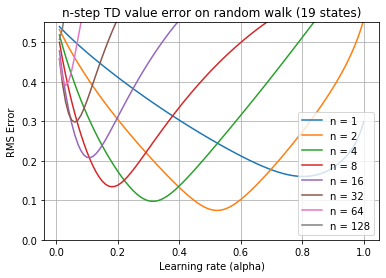

In [82]:
# Plot results
states = game.states[1:size+1]

fig, ax = plt.subplots()

for n, rms_errors in rms_error_sets.items():
    ax.plot(learning_rates, rms_errors, label='n = %d' % n)
plt.title('n-step TD value error on random walk (%d states)' % game.size)
ax.set_xlabel('Learning rate (alpha)')
ax.set_ylabel('RMS Error')
ax.set_ylim(0.0, 0.55)
plt.legend()
plt.grid()
#plt.savefig("random_walk_tdl_%d.pdf" % game.size)
plt.show()


Reference image (seed = 5): WHEN USING np.random.RandomState()

<img src="random_walk_tdl_19_copy.png">

### Test new n-step class on tictactoe

In [83]:
from tictactoe import TicTacToeGame, TicTacToeExpert, test_player
from gamelearner import RandomPlayer, TDLearner, GameController

In [84]:
game = TicTacToeGame()
game.show_state()

TypeError: 'NoneType' object is not iterable

In [ ]:
p1 = RandomPlayer(seed=1)
p2 = Agent(RandomPolicy(seed=5), name="Random", initial_value=0.0, 
           gamma=1.0)
p2.initialize(game, role=1)
p2.t

In [ ]:
p1.make_move(game, 1)
game.show_state()

In [ ]:
rewards = game.get_rewards()
rewards

In [ ]:
%pdb on
#p2.update(game, rewards[2])
%pdb off
p2.t += 1
p2.t

In [ ]:
p2.make_move(game, 2)
game.show_state()

In [ ]:
rewards = game.get_rewards()
rewards

In [ ]:
p1.make_move(game, 1)
game.show_state()

In [ ]:
rewards = game.get_rewards()
rewards

In [ ]:
%pdb on
p2.update(game, rewards[2])
%pdb off
p2.t += 1
p2.t

In [ ]:
p2.value_function

In [ ]:
p2.make_move(game, 2)
game.show_state()

In [ ]:
rewards = game.get_rewards()
rewards

In [ ]:
p1.make_move(game, 1)
game.show_state()

In [ ]:
rewards = game.get_rewards()
rewards

In [ ]:
%pdb on
p2.update(game, rewards[2])
%pdb off
p2.t += 1
p2.t

In [ ]:
p2.value_function

In [ ]:
p2.make_move(game, 2)
game.show_state()

## 8.7 Real-Time Dynamic Programming

### Exercise 8.8

In [ ]:
import numpy as np

class RandomStatesExperiment():

    name = 'Random States Experiment'
    roles = [1]
    possible_n_players = [1]
    help_text = {
        'Move format': "0 or 1",
        'Move not available': "That action is not available.",
        'Number of players': "This game is for 1 player."
    }

    def __init__(self, b, size=1000, moves=None, 
                 terminal_reward=0.0, seed=1):
        """Experiment described in section 8.6 of Sutton
        and Barto book to test Trajectory Sampling
        methods.

        Args:
            b (int): Branching factor.
            size (int): Number of states.
            moves (list): Optional. Provide a list of completed
                moves. Each move should be a tuple of length 2
                where the first item is the player role (1) and
                the second is the action (0 or 1).
            terminal_reward (float): Final reward when terminal
                state is reached.
            seed (int): Change this to produce a different
                random environment.
        """

        self.b = b
        self.size = size
        self.seed = seed

        self.states = np.arange(0, size + 1)

        # Last state is terminal state
        self.terminal_states = [self.states[-1]]

        # Initialize a random number generator for
        # generating random state transitions and
        # rewards
        self.rng = np.random.RandomState(seed)

        # First, create random state transitions
        self.transitions = {}
        for s in self.states:
            actions = self.available_moves(state)
            for a in actions:
                # Add b possible next states
                next_states = list(zip(
                    [0.9/b]*b, 
                    zip(self.rng.choice(self.states[:-1], size=b),
                        self.rng.normal(size=self.b))
                ))
                # Add the possibility of going to terminal state
                next_states.append((0.1, (self.terminal_states[0], 
                                          terminal_reward)))
                self.transitions[(s, a)] = next_states

        self.start_state = self.rng.choice(self.states)
        self.terminal_reward = terminal_reward
        
        self.n_players = 1
        self.turn = 1
        self.winner = None
        self.game_over = False
        self.past_states = None
        self.moves = None
        self.reset()
        if moves is not None:
            for move in moves:
                self.make_move(move)

    def reset(self):

        self.past_states = []
        self.moves = []
        self.state = self.start_state
        self.winner = None
        self.game_over = False

    def show_state(self):

        print(self.state)

    def available_moves(self, state=None):

        return (0, 1)

    def next_state(self, state, move):

        role, action = move

        next_states = [
            s2_and_r[0] for p, s2_and_r
            in self.transitions[(state, action)]
        ]
        probs = [
            p for p, s2_and_r
            in self.transitions[(state, action)]
        ]

        next_state = np.random.choice(next_states, p=probs)

        return next_state

    def update_state(self, move):

        self.state = self.next_state(self.state, move)

    def make_move(self, move, show=False):
        
        assert self.game_over is False, "Game is over"

        self.past_states.append(self.state)
        self.update_state(move)
        self.moves.append(move)

        if show:
            role, action = move
            print("Player %s made move %s" % (str(role), str(action)))

        self.check_if_game_over()

    def get_rewards(self):
        """Returns the reward at the current time step.  In
        this experiment, the reward of each transition is
        different and selected from a Gaussian distribution.
        Rather than store all the fixed rewards in memory,
        we regenerate them deterministically when needed using
        a seeded random number generator.
        """

        # Use previous state + seed to set RNG state
        # so that rewards are deterministic for any
        # state transition
        self.rng.seed(self.states[-1] + self.seed)
        last_action = self.moves[-1][1]

        # Return the reward for the last action taken
        reward = self.rng.normal(size=self.b)[last_action]

        return {1: reward}

    def get_terminal_rewards(self):
        """Returns the reward after the terminal state was
        reached."""

        assert self.game_over

        return {1: 0.0}   

    def check_if_game_over(self):

        if self.state in self.terminal_states:
            self.game_over, self.winner = True, 1

        return self.game_over

    def generate_state_key(self, state, role):

        return self.state

    def __repr__(self):

        return "RandomWalkGame(%d)" % self.size

In [ ]:
game = RandomStatesExperiment(b=5, size=1000)

In [ ]:
# Game has 1000 states + a terminal state
len(game.states)

In [ ]:
# Start state is chosen randomly, terminal state is 1000
game.start_state, game.terminal_states

In [ ]:
# From each state, there are two possible actions (0, 1)
# Each action leads to b possible next states with equal
# probability, or to the terminal state with probability 0.1

# Transitions from current state with action 0
game.transitions[(game.state, 0)]

In [ ]:
# Transitions from current state with action 1
game.transitions[(game.state, 1)]

In [ ]:
game.show_state()

In [ ]:
game.available_moves()

In [ ]:
# Test next_state function by finding all possible 
# next states if action 0 taken
next_states = set()

# iterate many times to make sure we catch them all
for i in range(100):
    next_states.add(game.next_state(game.state, (1, 0)))
next_states

In [ ]:
# Find all possible next states if action 1 taken
next_states = set()

# iterate many times to make sure we catch them all
for i in range(100):
    next_states.add(game.next_state(game.state, (1, 1)))
next_states

In [ ]:
game.roles, game.turn

In [ ]:
game.make_move([1, 0], show=True)
game.show_state()

In [ ]:
game.moves

In [ ]:
from gamelearner import RandomPlayer, TDLearner, GameController
td_player = TDLearner(off_policy_rate=0.0)
td_player.learning_rate, td_player.off_policy_rate

In [ ]:
game.reset()
ctrl = GameController(game, [td_player])
ctrl.play(show=True)

In [ ]:
list(td_player.value_function.items())[0:10]

In [ ]:
td_player.value_function[game.start_state]

In [ ]:
game.reset()

In [ ]:
values = {s: 0.0 for s in game.states}
len(values)

In [ ]:
list(values.items())[0:10]

In [ ]:
def random_policy(game, state, action, values=None):
    
    actions = game.available_moves(state=state)

    return 1.0/len(actions)

In [ ]:
def show_values(values, decimals=1):

    v_array = np.full((len(values)//10 + 1)*10, np.nan)
    for i, v in enumerate(values.values()):
        v_array[i] = v
    print(v_array)

show_values(values)

In [ ]:
values = evaluate_policy(random_policy, game, values, max_iter=100, 
                         show=False)

In [ ]:
show_values(values)

In [ ]:
pd.Series(values).hist()

In [ ]:
values[game.start_state]